In [1]:
import matplotlib.pyplot as plt
import numpy as np

import microtool

%matplotlib widget

# Inversion recovery

## 1. Create a tissue model specifying a T1 and T2

In [2]:
relaxation_model = microtool.tissue_model.RelaxationTissueModel(t1=900, t2=90)
print(relaxation_model)

Tissue model with 3 scalar parameters:
    - T1: 900 (scale: 900, optimize: False)
    - T2: 90 (scale: 90, optimize: True)
    - S0: 1.0 (scale: 1.0, optimize: False)


## 2. Create an initial inversion-recovery acquisition scheme
Initial TR = 500 ms, initial TE = 10 ms, initial TI = {50, ..., 400} ms

In [3]:
tr = np.array([500, 500, 500, 500, 500, 500, 500, 500])
te = np.array([10, 10, 10, 10, 20, 20, 20, 20])
ti = np.array([50, 100, 150, 200, 250, 300, 350, 400])

ir_scheme = microtool.acquisition_scheme.InversionRecoveryAcquisitionScheme(tr, te, ti)
print(ir_scheme)

Acquisition scheme with 8 measurements and 3 scalar parameters:
    - InversionTime: [ 50. 100. 150. 200. 250. 300. 350. 400.] ms
    - RepetitionTimeExcitation: [500. 500. 500. 500. 500. 500. 500. 500.] ms
    - EchoTime: [10. 10. 10. 10. 20. 20. 20. 20.] ms


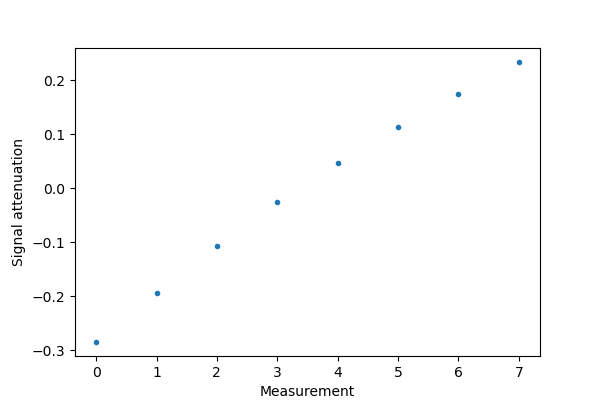

In [4]:
plt.figure(figsize=(6, 4))
plt.plot(relaxation_model(ir_scheme), '.')
plt.xlabel('Measurement')
plt.ylabel('Signal attenuation');

## 3. Optimize the acquisition scheme

In [5]:
noise_variance = 0.1
relaxation_model.optimize(ir_scheme, noise_variance,method=microtool.optimize.SOMA)

    fun: 1.77958264177713e-14
   nfev: 240175
 succes: True
      x: array([580.87611297, 577.54727358, 491.8552075 , 493.85327869,
       151.35467407,  88.48909051, 568.11673585, 403.81861633,
       145.40747926, 553.6352442 , 757.76756082, 393.03936933,
       577.98509864, 504.96501179, 509.72848336, 721.07309813,
        91.87964095,  91.88290265,  91.79297493,  91.85605121,
        91.87284212,  91.84314812,  91.8667071 ,  91.77959123])

Acquisition scheme with 8 measurements and 3 scalar parameters:
    - InversionTime: [58087.61129667 57754.72735825 49185.52074983 49385.32786902
 15135.4674071   8848.90905052 56811.67358494 40381.86163285] ms
    - RepetitionTimeExcitation: [14540.74792627 55363.52441977 75776.75608228 39303.93693301
 57798.50986438 50496.50117938 50972.84833561 72107.30981276] ms
    - EchoTime: [918.79640951 918.82902653 917.92974926 918.56051215 918.72842116
 918.4314812  918.667071   917.79591229] ms


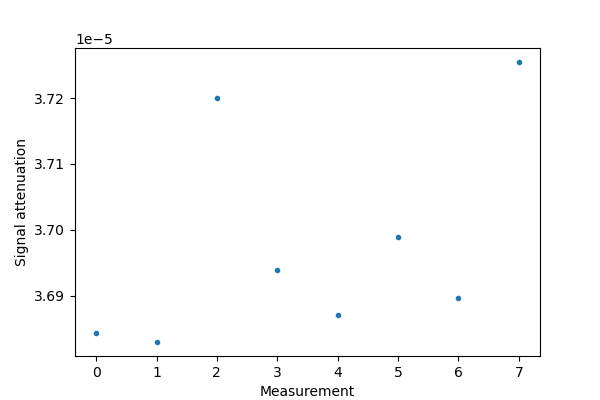

In [6]:
print(ir_scheme)
plt.figure(figsize=(6, 4))
plt.plot(relaxation_model(ir_scheme), '.')
plt.xlabel('Measurement')
plt.ylabel('Signal attenuation');

# dmpyi diffusion model

In [7]:
from dmipy.signal_models.cylinder_models import C1Stick
from dmipy.signal_models.gaussian_models import G1Ball
from dmipy.core.modeling_framework import MultiCompartmentModel

import microtool.dmipy

## 1. Create a 'stick' diffusion model

In [8]:
dmipy_model = MultiCompartmentModel(models=[
    C1Stick(
        mu=[1, 1],  # Orientation in angles.
        lambda_par=0.001 * 1e-6  # Parallel diffusivity in m²/s.
    )
])

We highly recommend installing pathos to take advantage of multicore processing.


## 2. Wrap the dmipy model in a DmipyTissueModel

In [9]:
diffusion_model = microtool.dmipy.DmipyTissueModel(dmipy_model)
diffusion_model

{'C1Stick_1_mu_0': TissueParameter(value=1.0, scale=1.0, optimize=True),
 'C1Stick_1_mu_1': TissueParameter(value=1.0, scale=1.0, optimize=True),
 'C1Stick_1_lambda_par': TissueParameter(value=array(1.e-09), scale=1e-09, optimize=True),
 'S0': TissueParameter(value=1.0, scale=1.0, optimize=False)}

## 3. Create an initial diffusion acquisition scheme

In [10]:
b_values = np.array([0, 1000, 2000, 3000])  # s/mm²
b_vectors = np.array([[0, 1, 0], [1, 0, 0], [0, 1, 0], [0, 0, 1]])
pulse_widths = np.full(b_values.shape, 10)  # ms
pulse_intervals = np.full(b_values.shape, 30)  # ms

diffusion_scheme = microtool.acquisition_scheme.DiffusionAcquisitionScheme(b_values, b_vectors, pulse_widths, pulse_intervals)
print(diffusion_scheme)

Acquisition scheme with 4 measurements and 5 scalar parameters:
    - DiffusionBValue: [   0. 1000. 2000. 3000.] s/mm²
    - DiffusionGradientAnglePhi: [0.         0.         1.57079633 0.        ] rad (fixed parameter)
    - DiffusionGradientAngleTheta: [1.57079633 1.57079633 1.57079633 0.        ] rad (fixed parameter)
    - DiffusionPulseWidth: [10. 10. 10. 10.] ms (fixed parameter)
    - DiffusionPulseInterval: [30. 30. 30. 30.] ms (fixed parameter)


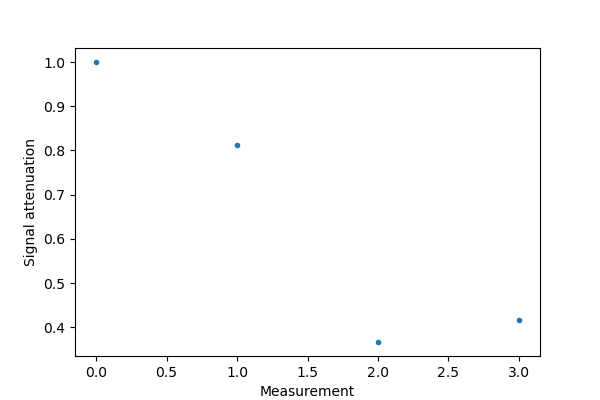

In [11]:
plt.figure(figsize=(6, 4))
plt.plot(diffusion_model(diffusion_scheme), '.')
plt.xlabel('Measurement')
plt.ylabel('Signal attenuation');

## 4. Calculate the Cramer-Rao lower bound loss

In [12]:
jacobian = diffusion_model.jacobian(diffusion_scheme)  # Jacobian of the signal with respect to the relevant tissue parameters.
scales = [p.scale for p in diffusion_model.values()]  # Tissue parameter scales.
include = [p.optimize for p in diffusion_model.values()]  # Include tissue parameter in optimization?
noise_variance = 0.1
microtool.optimize.crlb_loss(jacobian, scales, include, noise_variance)

21.656251987984398

## 5. Optimize the acquisition scheme

In [13]:
diffusion_model.optimize(diffusion_scheme, noise_variance);

c:\Users\fotto2\Anaconda3\envs\microdev\lib\site-packages\dmipy\core\acquisition_scheme.py:179: UserWarning: No b0 measurements were detected. Check if the b0_threshold option is high enough, or if there is a mistake in the acquisition design.
  warn(msg)
c:\Users\fotto2\Anaconda3\envs\microdev\lib\site-packages\dmipy\utils\utils.py:333: RuntimeWarning: invalid value encountered in true_divide
  theta = np.arccos(z / r)


Acquisition scheme with 4 measurements and 5 scalar parameters:
    - DiffusionBValue: [ 548.03352889  624.50562777 3228.50362764   14.46784879] s/mm²
    - DiffusionGradientAnglePhi: [0.         0.         1.57079633 0.        ] rad (fixed parameter)
    - DiffusionGradientAngleTheta: [1.57079633 1.57079633 1.57079633 0.        ] rad (fixed parameter)
    - DiffusionPulseWidth: [10. 10. 10. 10.] ms (fixed parameter)
    - DiffusionPulseInterval: [30. 30. 30. 30.] ms (fixed parameter)


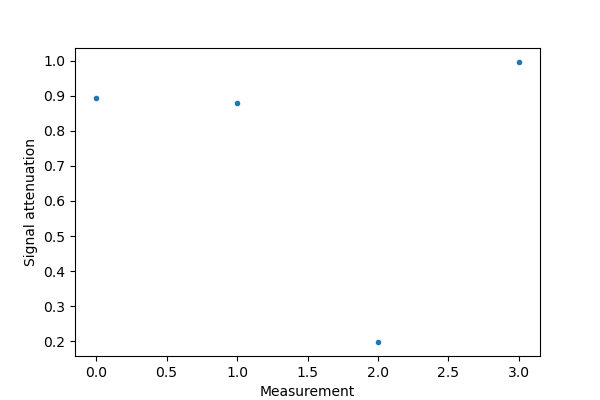

In [14]:
print(diffusion_scheme)
plt.figure(figsize=(6, 4))
plt.plot(diffusion_model(diffusion_scheme), '.')
plt.xlabel('Measurement')
plt.ylabel('Signal attenuation');

## 6. Calculate the Cramer-Rao lower bound loss again
It should be lower after optimizing the acquisition.

In [15]:
jacobian = diffusion_model.jacobian(diffusion_scheme)  # Jacobian of the signal with respect to the relevant tissue parameters.
scales = [p.scale for p in diffusion_model.values()]  # Tissue parameter scales.
include = [p.optimize for p in diffusion_model.values()]  # Include tissue parameter in optimization?
noise_variance = 0.1
microtool.optimize.crlb_loss(jacobian, scales, include, noise_variance)

c:\Users\fotto2\Anaconda3\envs\microdev\lib\site-packages\dmipy\core\acquisition_scheme.py:179: UserWarning: No b0 measurements were detected. Check if the b0_threshold option is high enough, or if there is a mistake in the acquisition design.
  warn(msg)


5.575679811677693

# MISST diffusion model

## 1. Set the path to the MISST MATLAB package

In [16]:
import microtool.misst
microtool.misst.set_misst_path(r'C:\development\MISST')

ImportError: MISST models require the MATLAB engine API for Python, which was not found. Install it as described in: https://www.mathworks.com/help/matlab/matlab_external/install-the-matlab-engine-for-python.html

## 2. Create a 'Cylinder' diffusion model and wrap it in a MisstTissueModel

In [ ]:
misst_model = {
    'di': microtool.tissue_model.TissueParameter(value=2e-9, scale=1e-9),  # Intrinsic diffusivity in m²/s.
    'rad': microtool.tissue_model.TissueParameter(value=5.2e-6, scale=1e-6, optimize=False),  # Cylinder radius in m.
    'theta': microtool.tissue_model.TissueParameter(value=0.1, scale=1),  # Angle from z axis
    'phi': microtool.tissue_model.TissueParameter(value=0.2, scale=1),  # Azimuthal angle
}

In [ ]:
diffusion_model = microtool.misst.MisstTissueModel('Cylinder', misst_model)
print(diffusion_model)

## 3. Create an initial diffusion acquisition scheme

In [ ]:
b_values = np.array([0, 500, 1000, 1500, 2000, 2500, 3000])  # s/mm²
b_vectors = np.array([[0, 1, 0], [1, 0, 0], [1, 0, 0], [0, 1, 0], [0, 1, 0], [0, 0, 1], [0, 0, 1]])
pulse_widths = np.full(b_values.shape, 10)  # ms
pulse_intervals = np.full(b_values.shape, 30)  # ms

diffusion_scheme = microtool.acquisition_scheme.DiffusionAcquisitionScheme(b_values, b_vectors, pulse_widths, pulse_intervals)
print(diffusion_scheme)

## 4. Optimize the acquisition scheme

In [ ]:
noise_variance = 0.1
diffusion_model.optimize(diffusion_scheme, noise_variance);

In [ ]:
print(diffusion_scheme)
plt.figure(figsize=(6, 4))
plt.plot(diffusion_model(diffusion_scheme), '.')
plt.xlabel('Measurement')
plt.ylabel('Signal attenuation');